# Report Title

---

_**Brief Report Objective**_

---


## Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Validation and Cleaning](#Data-Validation-and-Cleaning)
1. [Train Test Split](#Train-Test-Split)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Feature Engineering](#Feature-Engineering)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Baseline Model](#Baseline-Model)
1. [Model Building, Selection, and Evaluation](#Model-Building-Selection-and-Evaluation)
1. [Baseline Model Comparison](#Baseline-Model-Comparison)
1. [Final Model Evaluation](#Final-Model-Evaluation)
1. [Conclusion](#Conclusion)
1. [Appendix](#Appendix)

---


### Introduction

**Objective**: Extended Report Objective (What type of Machine Learning task is this ? What are you looking to find out ?)

Our dataset we are analyzing contains information about **{{ data_description }}**. It has **{{ data_columns }}** columns and **{{ data_rows }}** rows.

The columns of the dataset are:
1. `predictor_column_1` - *description*
1. `predictor_column_2` - *description*
1. `predictor_column_3` - *description*
1. `predictor_column_4` - *description*
1. `target_column` **(target)** - *description*

We are trying to predict `target_column` using the other variables as our predictors. 

First, we will perform *exploratory data analysis* (EDA) to better understand the relationships of our predictors to `target_column`. Next, we will *create new features from our existing data* (feature engineering) to explore new relationships with `target_column` with the hope of increase our model's predcitive power. We will then transform our data into a format our models understand and evaluate their performance using *cross validation*, and choose a few candidate models to fine tune. Once we have fine tuned the hyperparameters of our candidate models, we can evaluate their performance using *cross validation*, and select the model which performed the best. This allows us to estimate our model will do in *production* (ie, how well it will predict future observations). Finally, we will tie together all of the steps from into a *pipeline* so that our code is as compact and understandable as possible and perform one final evaluation on our test set.

---

### Setup

Import all the Python libraries we will need

---

In [82]:
# Add imports here
import itertools
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import scipy.stats
import phik

In [83]:
# Read in Data from Database
# conn = os.environ["DB_URL"]
# query = ""
# data = pd.read_sql(query, con=conn)
# Read in Data from CSV
# data = pd.read_csv("path_to_csv.csv")
data = pd.read_csv("../data/mopeds.csv")

# Preview Dataframe
data.head()

# If problems are identified in preview fix them here (wrong column headers, wrong delimiter, etc.)

,owned,make_model,review_month,web_browser,reviewer_age,primary_use,value_for_money,overall_rating
0,1,Nielah-Eyden,Oct,Chrome,23,Commuting,5/10,18.62
1,0,Nielah-Keetra,Jun,NaN,24,Commuting,4/10,15.55
2,0,Lunna-Keetra,23-Oct,Chrome,28,Commuting,5/10,12.76
3,1,Hoang-Keetra,07-Nov,IE,41,Leisure,5/10,17.07
4,1,Lunna-Keetra,16-Sep,Chrome,33,Leisure,5/10,12.29


### Data Validation and Cleaning

---

In [84]:
# Drop duplicates
duplicate_count = len(data) - len(data.drop_duplicates())
if duplicate_count > 0:
    print(f"{duplicate_count} duplicate rows found\nTo examine them run: data[data.duplicated(keep=False)]\nTo drop them run: data.drop_duplicates(inplace=True)")
    data.drop_duplicates(inplace=True)
    print(f"Dropped {duplicate_count} duplicate rows")

In [85]:
# Shape of data, dtypes, NULL Counts, duplicate rows, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types

# Shape of data
print(f"Dataframe has {data.shape[0]} rows and {data.shape[1]} columns")
print("\n")

# Data Types and Missing Values
print(f"Data Types, Missing Values Per Column, and Unique Values Per Column:\n")
df_overview = pd.DataFrame({
    "Column Name": data.columns,
    "Data Type": data.dtypes,
    "# Missing Values": data.isnull().sum(),
    "% Missing Values": data.isnull().mean() * 100,
    "Unique Values": data.nunique()
}).sort_values(by=["Data Type", "% Missing Values"]).reset_index(drop=True)
display(df_overview)
print("\n")

# Data Types Counts
print(f"Data Types Counts:\n")
display(data.dtypes.value_counts())

Dataframe has 1500 rows and 8 columns


Data Types, Missing Values Per Column, and Unique Values Per Column:



,Column Name,Data Type,# Missing Values,% Missing Values,Unique Values
0,owned,int64,0,0.0,2
1,overall_rating,float64,0,0.0,583
2,make_model,object,0,0.0,6
3,review_month,object,0,0.0,332
4,reviewer_age,object,0,0.0,36
5,primary_use,object,0,0.0,2
6,value_for_money,object,0,0.0,10
7,web_browser,object,150,10.0,6




Data Types Counts:



object     6
int64      1
float64    1
dtype: int64

Numeric Variables Summary Statistics



,owned,overall_rating
count,1500.000000,1500.000000
mean,0.593333,17.138907
std,0.491375,2.445566
min,0.000000,11.690000
25%,0.000000,15.320000
50%,1.000000,18.240000
75%,1.000000,18.840000
max,1.000000,22.760000


Distributions of Numeric Columns:



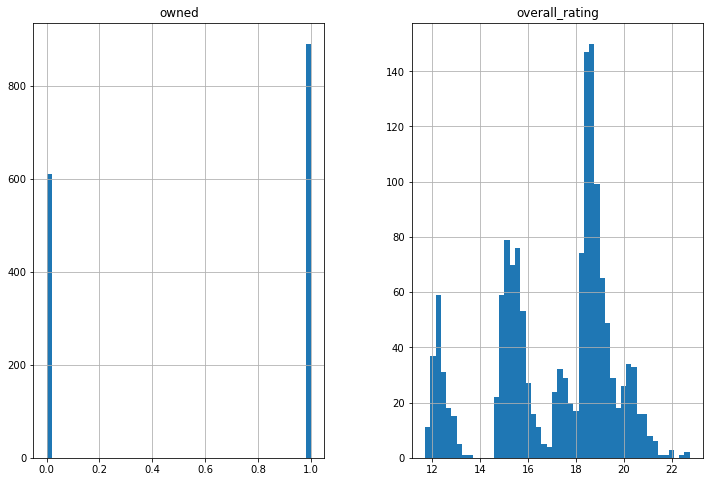

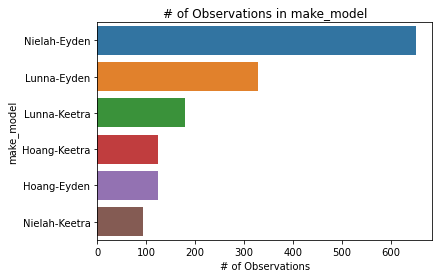

🚨 review_month column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨
Here are the 5 most common values:
Sep    73
Mar    72
May    68
Nov    67
Apr    65
Name: review_month, dtype: int64


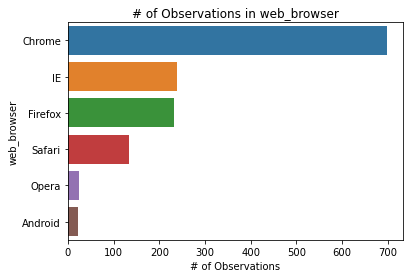

🚨 reviewer_age column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨
Here are the 5 most common values:
-     105
19     52
41     51
45     50
18     46
Name: reviewer_age, dtype: int64


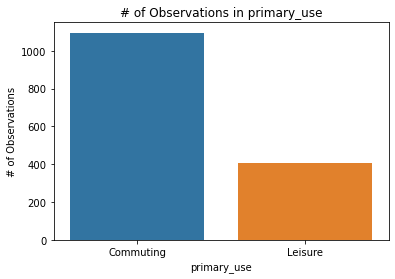

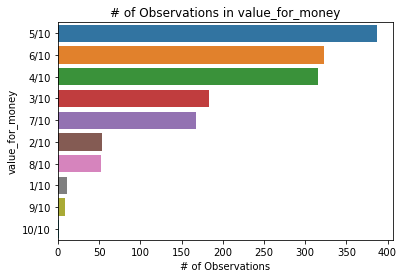

In [86]:
# Summary Statistics
print(f"Numeric Variables Summary Statistics\n")
display(data.describe())

# Distributions of Numeric Columns
print(f"Distributions of Numeric Columns:\n")
data.hist(figsize=(12, 8), bins=50)
plt.show()

# Count plots of categorical columns
for col_name in data.select_dtypes(exclude="number").columns:
    nunique = data[col_name].nunique()
    desc_order = data[col_name].value_counts().index
    if nunique > 5 and nunique < 20:
        sns.countplot(data=data, y=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.xlabel("# of Observations")
        plt.ylabel(col_name)
        plt.show()
    elif nunique <= 5:
        sns.countplot(data=data, x=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.ylabel("# of Observations")
        plt.xlabel(col_name)
        plt.show()
    else:
        print(f"🚨 {col_name} column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨")
        print(f"Here are the 5 most common values:\n{data[col_name].value_counts().head(5)}")

**{{ make observation on what needs to be cleaned up or addressed now vs later }}**

**Changing of dtypes, handling of nulls, high cardinality categorical variables, etc.**

* Are some columns the wrong datatype ?
* Are there columns with a lot of NULL values ?
* Are there categorical columns with > 4 categories ?
* Could some columns be better represented via binning ? (Converting a `numeric` variable into `catgeorical`)

**Distribution Types, Outliers, General Aknowledgements**

* Are any distributions skewed? Consider applying some common transformations (square root, log, etc.) in the preprocessing step of your pipeline.
  * Features that are strictly positive and have a heavy right tail generally benefit from square root or raising to a power between 0 and 1. Features with a very long and heavy tail (such as a power law distribution) generally benefit from replacing the feature with its logarithm.
  * In simpler words, if the feature's values spread out to the right, but not too rapidly, use the square root transformation. If the values spread out significantly and decrease very quickly as they get larger, then the log transformation can be more appropriate.

* Do you notice any common distributions (Normal, Bimodal, Exponential, etc.) ?
  * What does impact does this have on Data Preprocessing (Scaling, Centering, etc.) ?
  * What techniques can be used for 

* Are there a lot of outliers for any of the columns ?

* Do any variables lend themselves to binning / are there "numeric" variables that actually represent discrete categories ?
  * Be aware of impacts on model. If you use a linear model and predictor has a linear relationship with target, then binning isn't recommended.

* Did some of the distributions lead you to a follow up question (check outliers, etc.) ? If so explore them here

* Are there very few observations for any of the classes of a variable ?
  * Should you use stratified sampling?
  * What does impact does this have on Data Preprocessing (Train Test Split / classes in Train but not Test) ?

In [87]:
# Clean data / address issue to fix now

# 🚨 Before you do any more EDA, you need to split your data into training and test sets and never look at the test set 🚨

In [88]:
from sklearn.model_selection import train_test_split

# 🚨 Replace with target column name 🚨
target = "owned"

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

### Numerical EDA

---

In [89]:
# Shape of train_data, dtypes, NULL Counts, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types, possible outliers etc.
## You can get a very good and quick EDA using pandas-profiling

# Create pandas_profiling EDA Report
profile = ProfileReport(train_data, title="Pandas Profiling Report")
# Display pandas_profiling EDA Report
profile.to_notebook_iframe()

# Identify Potential Outliers using the IQR Method
quant1 = []
quant3 = []
int_quartile_range = []
outlier_counts = []
for col_name in train_data.select_dtypes("number").columns:
    q1 = train_data[col_name].quantile(0.25)
    q3 = train_data[col_name].quantile(0.75)
    iqr = q3 - q1
    outlier_count = len(train_data[col_name][(train_data[col_name] < (q1 - 1.5 * iqr)) | (train_data[col_name] > (q3 + 1.5 * iqr))])
    outlier_counts.append(outlier_count)
    quant1.append(q1)
    quant3.append(q3)
    int_quartile_range.append(iqr)
outlier_df = pd.DataFrame({
    "column": train_data.select_dtypes("number").columns,
    "q1": quant1,
    "q3": quant3,
    "iqr": int_quartile_range,
    "outlier_count": outlier_counts
}).sort_values(by="outlier_count", ascending=False).reset_index(drop=True)
print(f"\nNumber of potential outliers per column (IQR method)\n")
print(f"To examine outliers run: train_data[((train_data[col_name] < (q1 - 1.5 * iqr)) | (train_data[col_name] > (q3 + 1.5 * iqr)))]")
display(outlier_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]


Number of potential outliers per column (IQR method)

To examine outliers run: train_data[((train_data[col_name] < (q1 - 1.5 * iqr)) | (train_data[col_name] > (q3 + 1.5 * iqr)))]


,column,q1,q3,iqr,outlier_count
0,owned,0.00,1.00,1.00,0
1,overall_rating,15.28,18.84,3.56,0


**{{ make_observations_here }}**

**Potential outliers, handling of nulls, high cardinality categorical variables, etc.**

* Did you forget to change some columns to the correct types ?
* Are there a lot of outliers for any of the columns ?
* Do any of the quantiles stick out right away ? Be sure to analyze these when doing Graphical EDA
* Check out some of the outliers and see if they could be legit outliers or not. Graphical EDA can help visualize this

### Graphical EDA

---

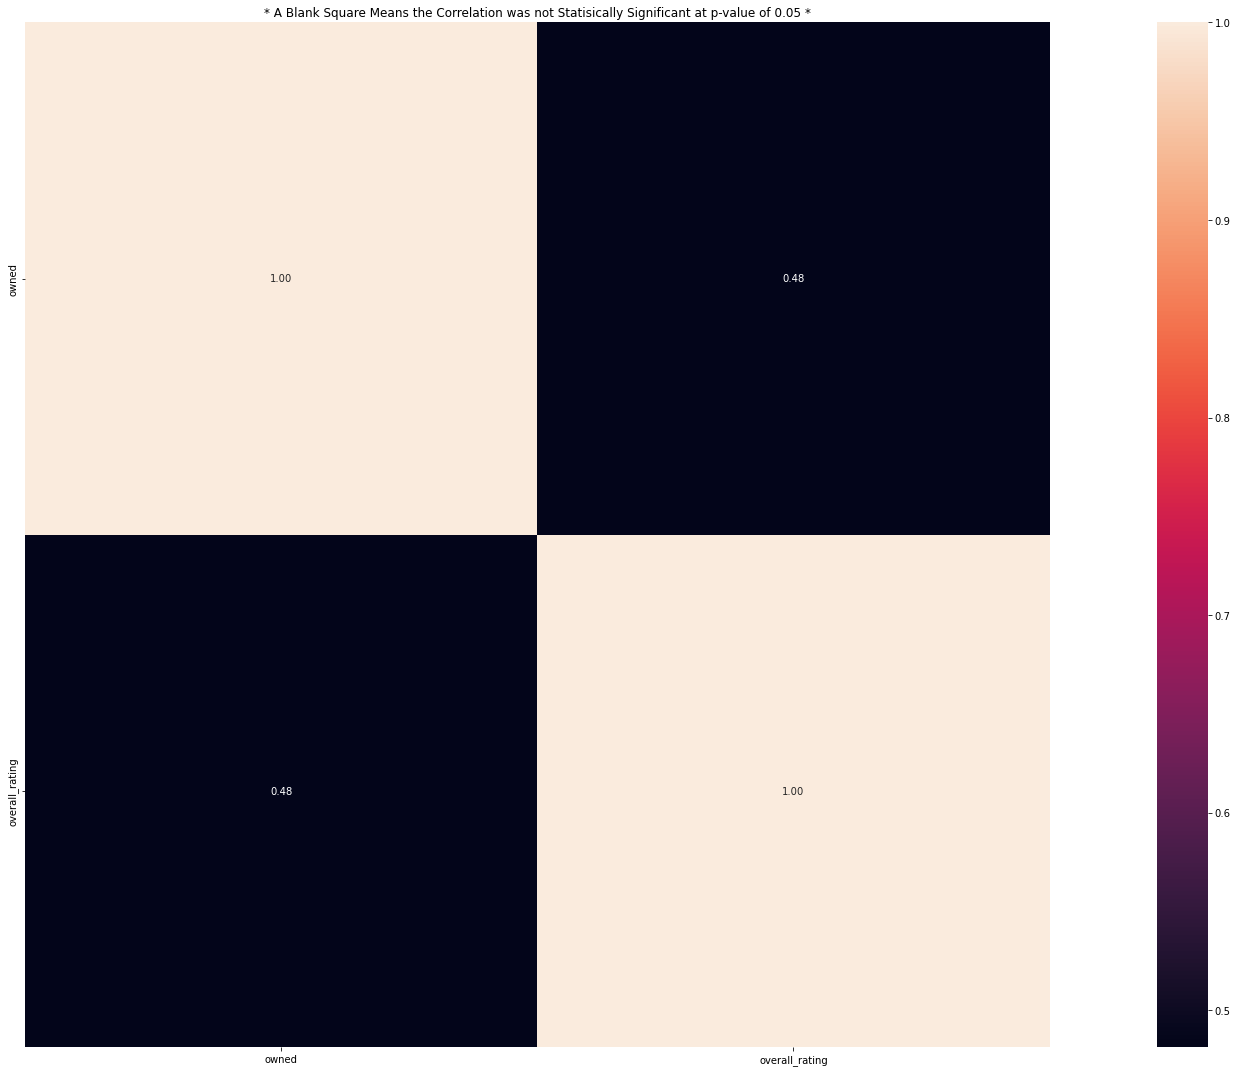

In [90]:
# Pearson's r Correlation Heatmap
# Correlation Matrix

# Code to "mask" correlations that are not statistically significant from heatmap
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = scipy.stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

# p_values = corr_sig(train_data.select_dtypes('number'))
# mask = np.invert(np.tril(p_values<0.05))

# Set up the matplotlib figure
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(30, 15))

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(train_data.corr(method="pearson"),
                    #    mask=mask,
                       annot=True,
                       fmt='.2f',
                       square=True)
g.set(title="* A Blank Square Means the Correlation was not Statisically Significant at p-value of 0.05 *")
f.set_tight_layout(True)

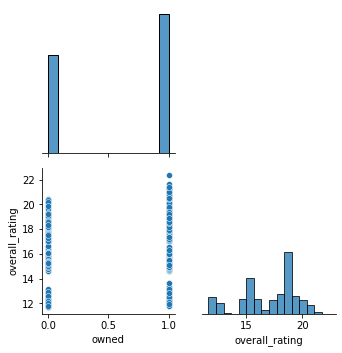

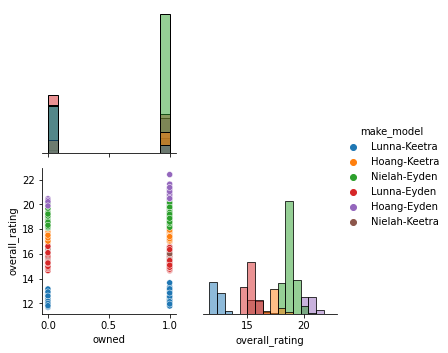

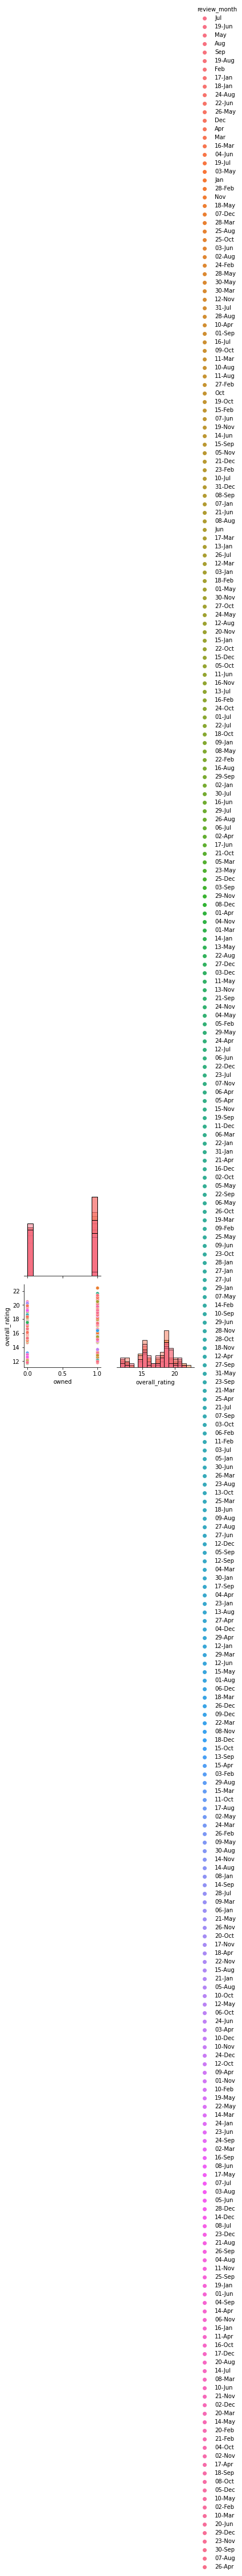

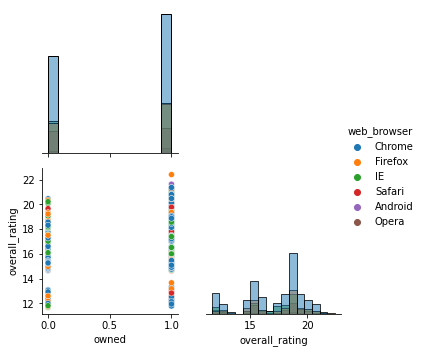

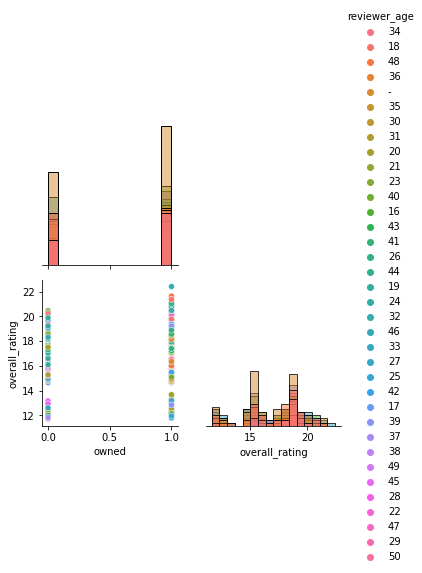

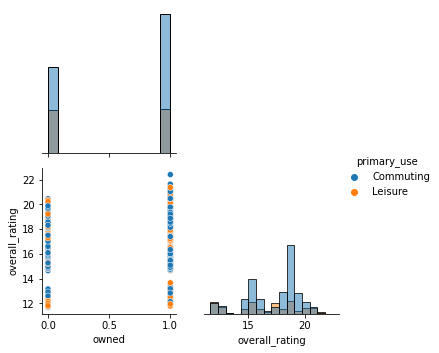

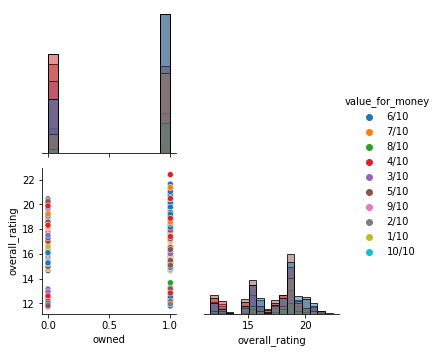

In [91]:
# Multiple Variables

# Relational

# No hue
g = sns.PairGrid(train_data, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

# With hue for each categorical variable
for col_name in train_data.select_dtypes(exclude="number").columns:
    g = sns.PairGrid(train_data, corner=True, hue=col_name)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()
    plt.show()

**{{ make_observations_here }}**

**Notable relationships to target, correlated predictors, predictor interactions relationships to target, etc.**

* Do any of variables have a noticable relationship to the target (Linear or Non-Linear) ?
  * What does impact does this have on type of models you will test ?
* Are any of the predictors highly correlated (linear correlation) with each other ?
  * [Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) may need to be addressed for Linear Models for interpretability, but does not impact predictive accuracy.
* Do you notice any interesting interactions (X-axis + color) on the target ?
  * If yes, then consider adding interaction terms during feature engineering.

In [92]:
def annotate_count_plot(g, kind=None):
    # Annotate the bars with the count at the top of each bar
    # iterate through axes
    if kind == 'percent':
        # Annotate the bars with the count at the top of each bar
        # iterate through axes
        for ax in g.axes.ravel():
            # add annotations
            for c in ax.containers:
                labels = [f'{round(100 * v.get_height(),2)} %' for v in c]
                ax.bar_label(c, labels=labels, label_type='edge')
            ax.margins(y=0.2)
    else:
        for ax in g.axes.ravel():
            # add annotations
            for c in ax.containers:
                labels = [f'{v.get_height()}' for v in c]
                ax.bar_label(c, labels=labels, label_type='edge')
            ax.margins(y=0.2)

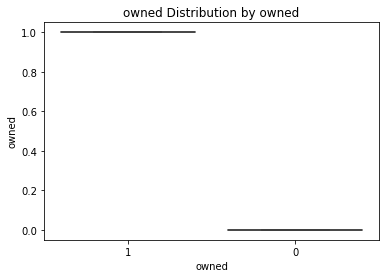

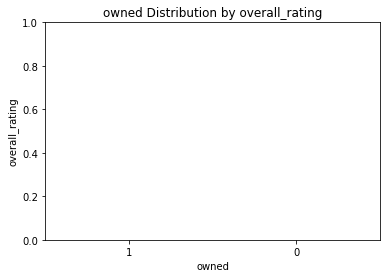

In [93]:
# Multiple Variables
for col_name in data.select_dtypes(include="number").columns:
    # Medians in descending order
    desc_order = data.groupby(by=[target])[col_name].median().sort_values(ascending=False).index
    g = sns.boxplot(data=data, x=col_name, y=target, order=desc_order)
    g.set(xlabel=target, ylabel=col_name)
    g.set_title(f"{target} Distribution by {col_name}")
    plt.show()

# Target vs Category for each Category
# g = sns.boxplot(data=data, y="fuelType", x=target)
# g.set(xlabel="Price ($)", ylabel="Fuel Type")
# g.set_title("Price Distribution by Fuel Type")
# plt.show()

**{{ make_observations_here }}**

**Interesting Interactions**

* Can you identify any relationships between categorical predictor classes and the target ?
  * If, so then try to dig deeper on this relationship when doing *3 variable interaction*
* Explore whether the relationships seen here are independent of other predictors or not
  * Create some hypothesis and test them with more plots

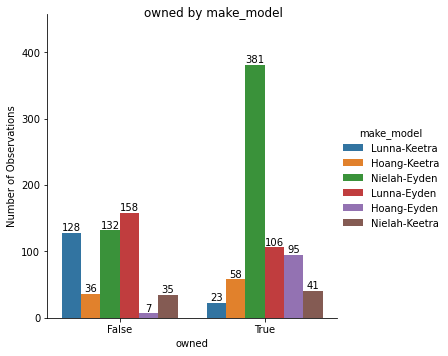

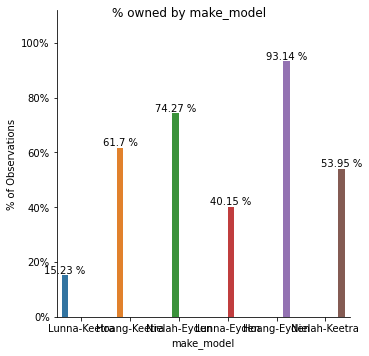

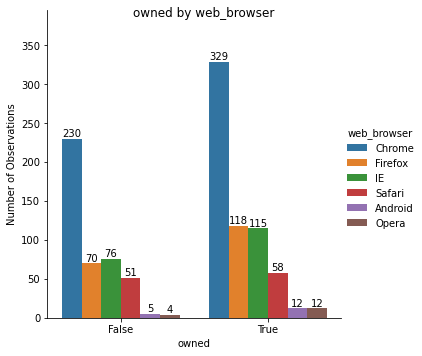

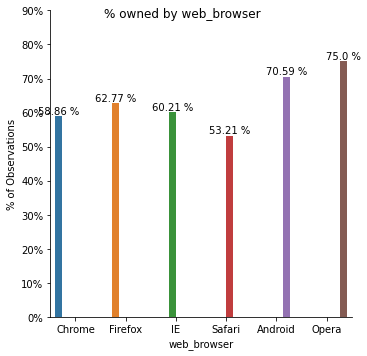

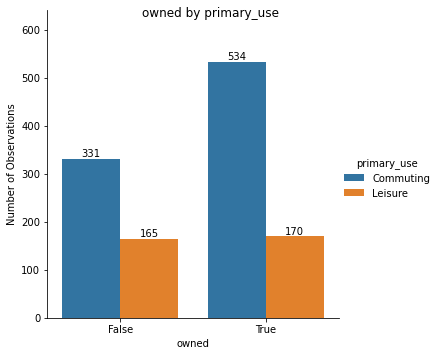

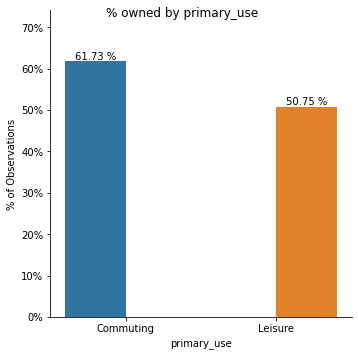

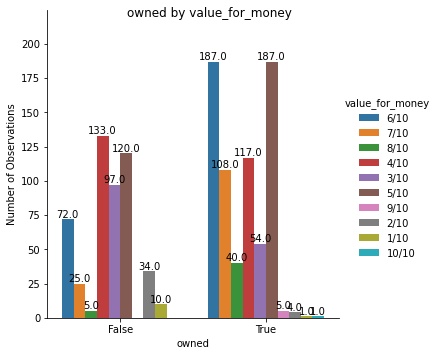

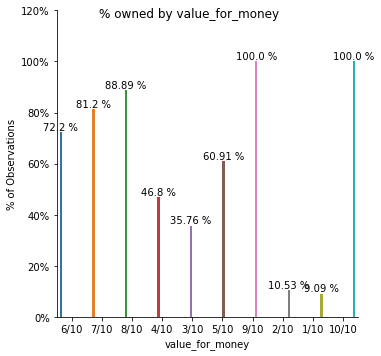

In [94]:
# Compare each of the following categorical variables relationship to Survived
small_categoricals = []
for col_name in data.drop(columns=[target]).select_dtypes(exclude="number").columns:
    nunique = data[col_name].nunique()
    if nunique <= 15:
        small_categoricals.append(col_name)
        
for category in small_categoricals:
    g = sns.catplot(data=train_data, x=target, hue=category, kind="count")
    g.set_ylabels("Number of Observations")
    g.fig.suptitle(f"{target} by {category}")
    g.set_xticklabels(["False", "True"])
    annotate_count_plot(g)
    plt.show()
    g = sns.catplot(data=train_data, x=category, y=target, hue=category, kind="bar", ci=False)
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(PercentFormatter(1))
    g.set_ylabels("% of Observations")
    g.fig.suptitle(f"% {target} by {category}")
    annotate_count_plot(g, kind="percent")
    plt.show()

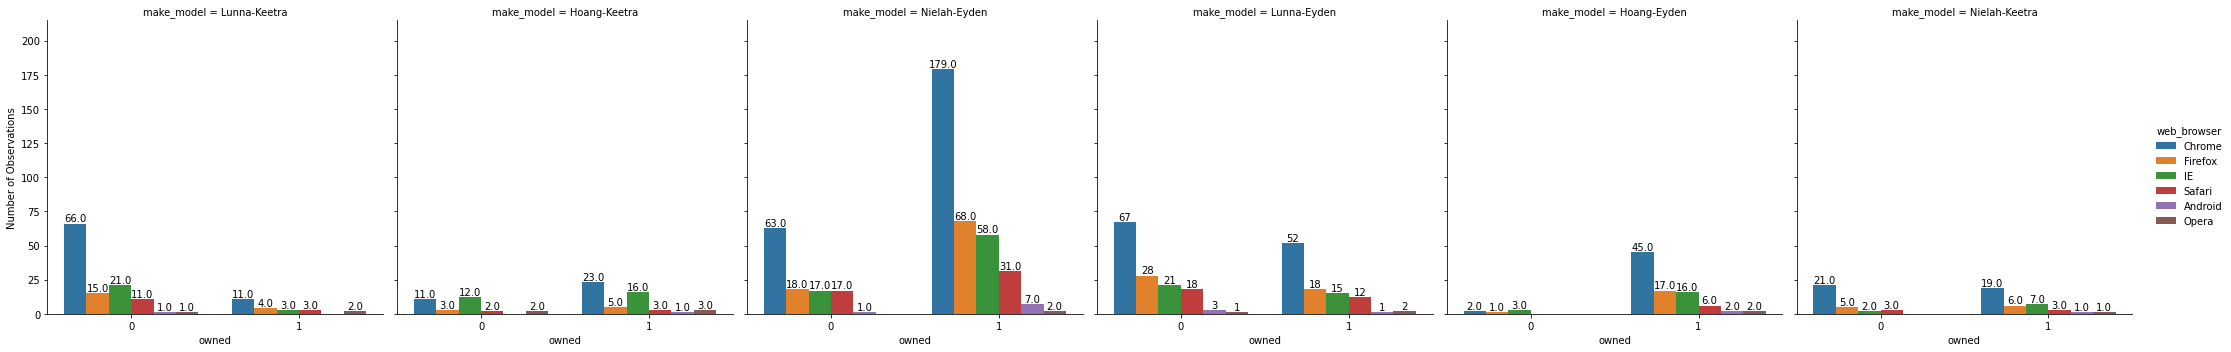

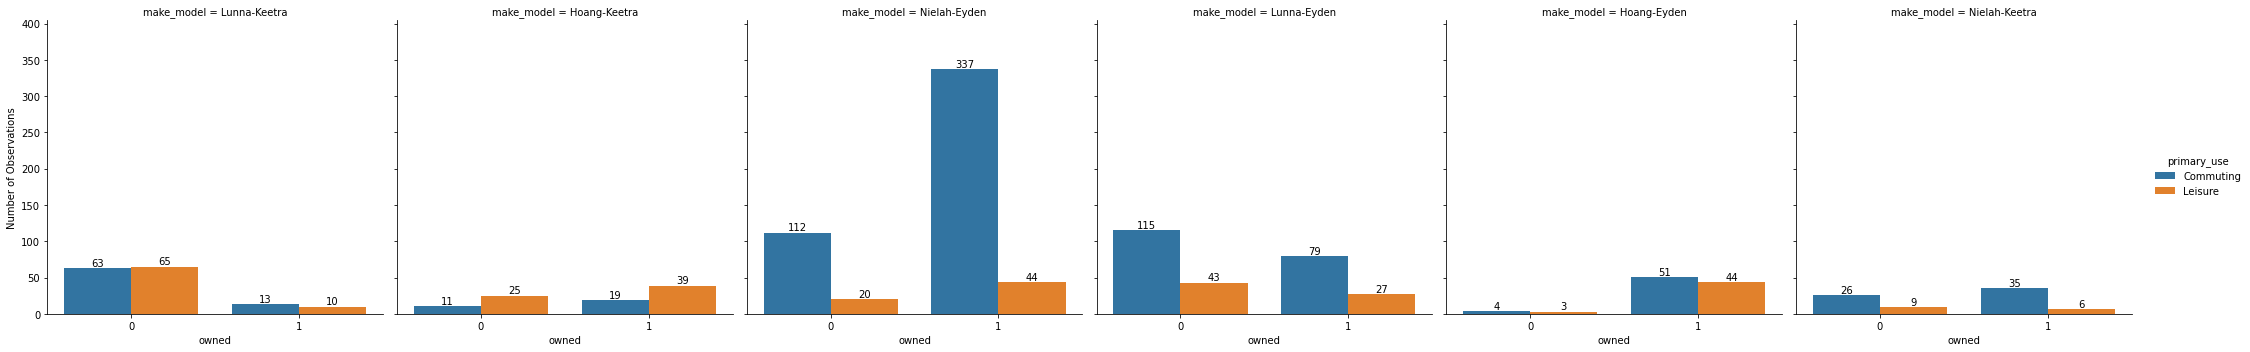

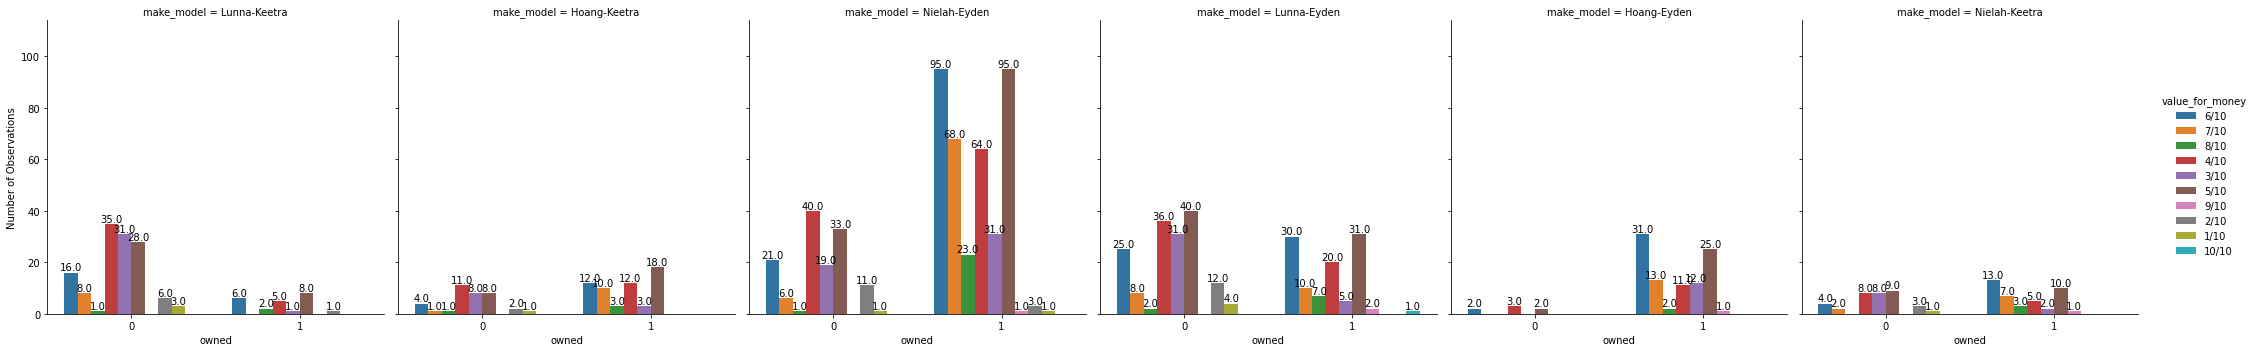

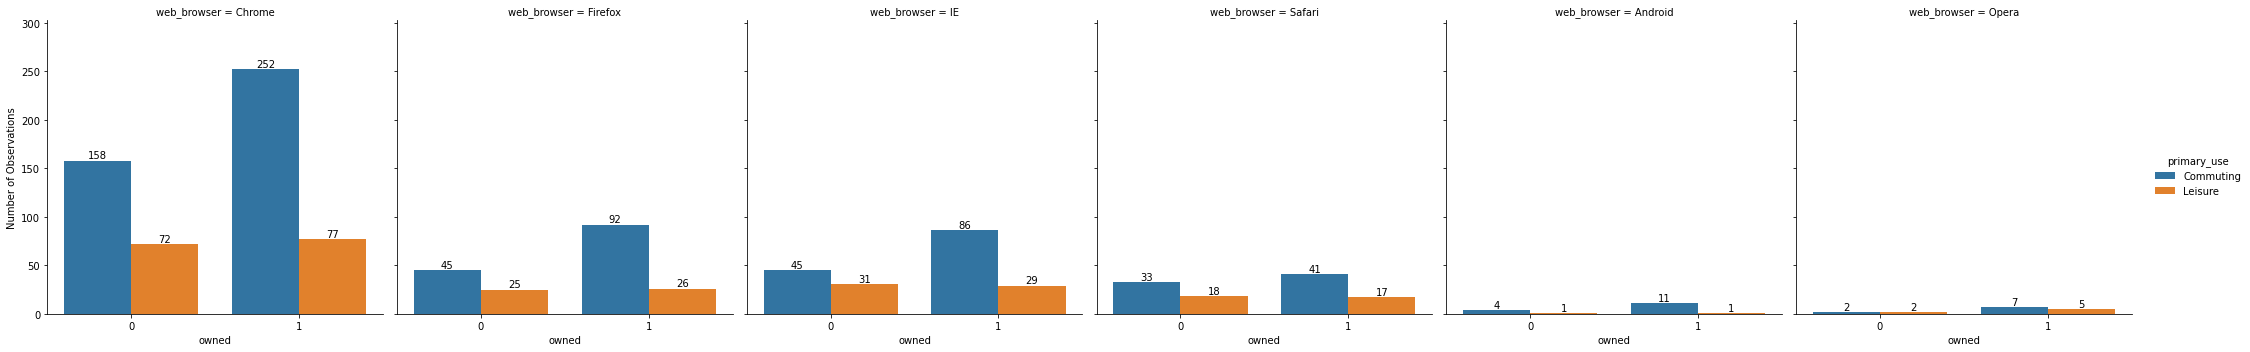

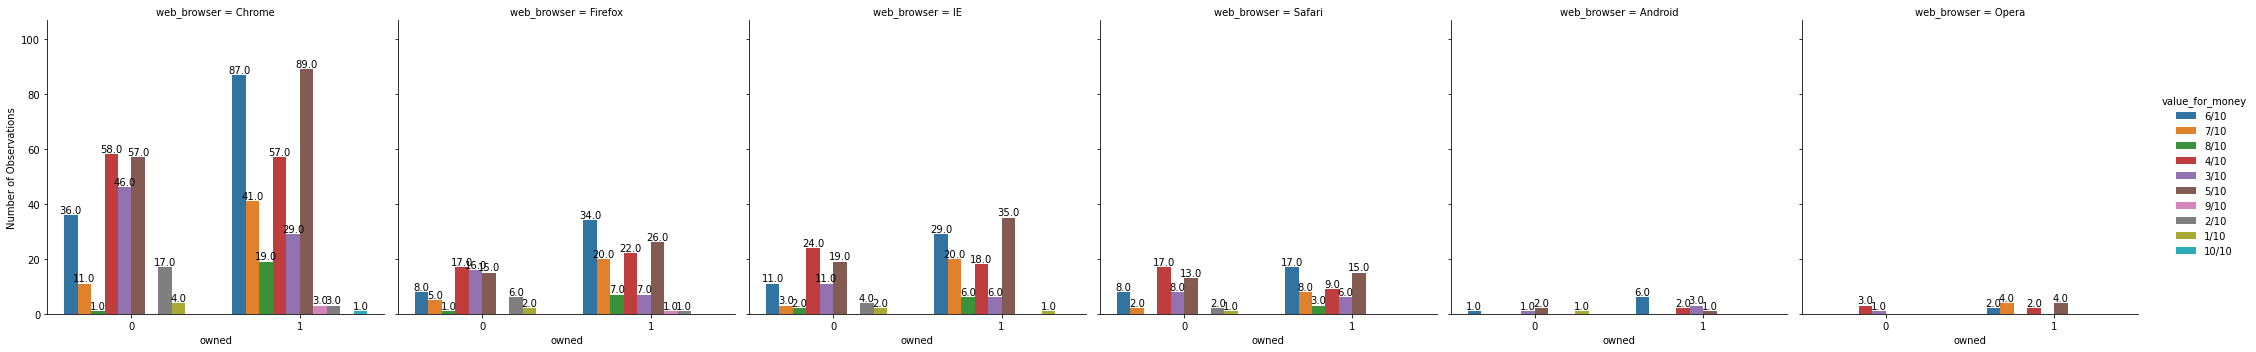

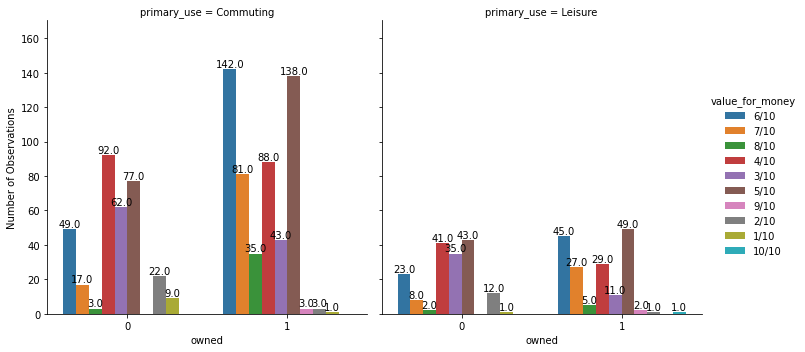

In [95]:
# Categorical Interactions and their relationship with Survived
all_combinations = itertools.combinations(small_categoricals, 2)
for combination in all_combinations:
    g = sns.catplot(data=train_data, x=target, col=combination[0], hue=combination[1], kind="count")
    g.set_ylabels("Number of Observations")
    # g.set_xticklabels(["False", "True"])
    # Annotate the bars with the count at the top of each bar
    annotate_count_plot(g)

**{{ make_observations_here }}**

**Interesting Interactions**

* Can you identify any relationships between categorical predictor classes and the target ?
* Did adding a 3rd variable expose a new trend that you didn't see as clearly with 2 variables ?

interval columns not set, guessing: ['owned', 'overall_rating']


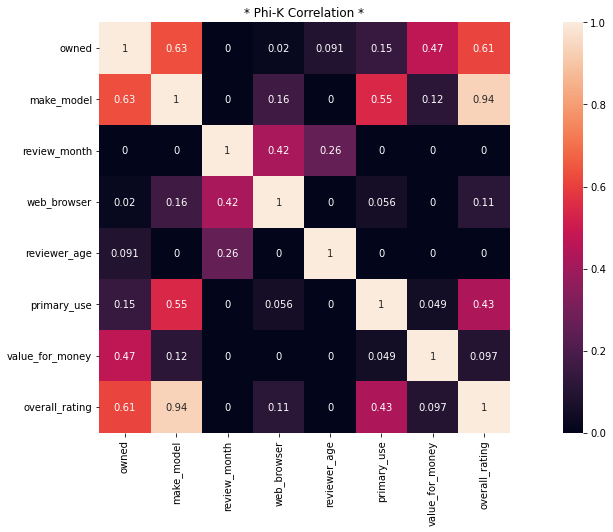

In [96]:
# Phi-k Correlations (Categorical and Numeric combined)
f, ax = plt.subplots(figsize=(15, 7.5))
g = sns.heatmap(data=train_data.phik_matrix(), annot=True, square=True)
g.set(title="* Phi-K Correlation *")
f.set_tight_layout(True)

### Feature Engineering

---

In [97]:
# Create new features based on hypothesis you want to test after EDA
# interaction terms, n-grams and tokenization, 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer

You should make your feature engineering functions and then apply them to the data as a step inside of your `sklearn.Pipeline`.

### Data Preprocessing

---

In [98]:
X_train = train_data.drop(columns=[target])
y_train = train_data[target].copy()

### Baseline Model

---

In [99]:
# Either use a simple model like Linear Regression / KNN or just the average value. You should be able to do better than this
from sklearn.metrics import accuracy_score, confusion_matrix

mode_y = data[target].mode()
print(f"Mode value of {target}")
print(f"Mode value of the target = {mode_y.iloc[0]}")
y_pred = [mode_y] * len(y_train)
baseline_accuracy = accuracy_score(y_train, y_pred)
print(f"Baseline Model Test Accuracy (using mode as the predicted value) = {baseline_accuracy:,.2f}")

Mode value of owned
Mode value of the target = 1
Baseline Model Test Accuracy (using mode as the predicted value) = 0.59


The baseline model simply used the average value as its prediction for each time. We need our model to be at least better than this simple baseline model's Accuracy.

**Add another baseline Accuracy here with a simple model**

### Model Building, Selection, and Evaluation

---

In [100]:
# import modules
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [101]:
# Define different Pipelines for Numeric vs. Categorical
# Categorical preprocessing
categorical_pipeline = Pipeline(steps=[
    ('categorical_imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"))
])

# Numeric preprocessing
numeric_pipeline = Pipeline(steps=[
    ('numeric_imputer', SimpleImputer(strategy="median")),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical preprocessing into single preprocessor
numeric_features = X_train.select_dtypes(include="number").columns
categorical_features = X_train.select_dtypes(exclude="number").columns
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical_preprocessor", categorical_pipeline, categorical_features),
        ("numeric_preprocessor", numeric_pipeline, numeric_features),
    ]
)


# Define a single Pipeline with all of the steps
models = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier()]
cv_accuracys = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        # Try different models and select the one with the best cross_val_score
        ('regressor', model)
    ]
    pipeline = Pipeline(steps)
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=4, scoring="accuracy")
    cv_accuracy = pd.Series(cv_accuracy)
    print(f"{model} Cross Validation Test Accuracy Distribution\n")
    display(cv_accuracy.describe())
    # Get the mean_test_score from the cross_val_score
    cv_accuracys.append(cv_accuracy.mean())

LogisticRegression() Cross Validation Test Accuracy Distribution



count    4.000000
mean     0.713333
std      0.007201
min      0.706667
25%      0.709167
50%      0.711667
75%      0.715833
max      0.723333
dtype: float64

KNeighborsClassifier() Cross Validation Test Accuracy Distribution



count    4.000000
mean     0.685000
std      0.022690
min      0.653333
25%      0.678333
50%      0.690000
75%      0.696667
max      0.706667
dtype: float64

RandomForestClassifier() Cross Validation Test Accuracy Distribution



count    4.000000
mean     0.721667
std      0.012323
min      0.706667
25%      0.714167
50%      0.723333
75%      0.730833
max      0.733333
dtype: float64

[13:44:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=Non

count    4.000000
mean     0.716667
std      0.016330
min      0.696667
25%      0.711667
50%      0.716667
75%      0.721667
max      0.736667
dtype: float64

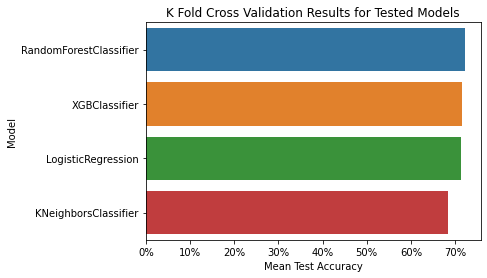

,model,cross_validation_accuracy
2,RandomForestClassifier,0.721667
3,XGBClassifier,0.716667
0,LogisticRegression,0.713333
1,KNeighborsClassifier,0.685000


Maximum cross validation Accuracy (0.72) acheived with RandomForestClassifier model


In [102]:
cv_results = pd.DataFrame({
    "model": [str(model).split("(")[0] for model in models],
    "cross_validation_accuracy": cv_accuracys
}).sort_values(by="cross_validation_accuracy", ascending=False)
sns.barplot(data=cv_results, y="model", x="cross_validation_accuracy")
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("K Fold Cross Validation Results for Tested Models")
plt.xlabel("Mean Test Accuracy")
plt.ylabel("Model")
plt.show()
display(cv_results)
best_model = cv_results.loc[cv_results['cross_validation_accuracy'].idxmax()]['model']
print(f"Maximum cross validation Accuracy ({max(cv_results['cross_validation_accuracy']):,.2f}) acheived with {best_model} model")

**Explicitly say which model you expect to perform the best and why.**

Cross validation lets us estimate how well our models will perform on the future data (like our Test set), thus we will proceed with the model that yields the lowest cross validation Accuracy.

The `model` yielded the lowest cross validation Accuracy, so will use it as our final model and proceed to tuning.

In [103]:
# Inspect parameters that we can tune with `model`.get_params().keys()

In [104]:
# Reset Pipeline with best model
steps = [
        ('preprocessor', preprocessor),
        ('regressor', RandomForestClassifier())
    ]
pipeline = Pipeline(steps)

# Set up the parameter distributions to search over
param_distributions = {}

# Tune the hyperparameters for the best model
cv = RandomizedSearchCV(pipeline
                  , cv = 4
                  , scoring="accuracy"
                  , param_distributions=param_distributions
                  , random_state=42)

cv.fit(X_train, y_train)

cv_results = pd.DataFrame(cv.cv_results_)

print(f"CV Results")
display(cv_results.sort_values(by="mean_test_score").head(5))
print(f"Best Hyperparameters\n{cv.best_params_}")

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CV Results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.163347,0.001888,0.012396,0.000367,{},0.716667,0.73,0.733333,0.726667,0.726667,0.006236,1


Best Hyperparameters
{}


After experimenting with feature extraction, feature selection, and other processing techniques, you should choose the model that yielded the lowest CV Accuracy on the training data.

If the tuned model had the lowest CV Accuracy, then make sure you use the hyperparameters you found when you do your final validation on the test set.

This will be the final model that you deploy for future predictions.

### Baseline Model Comparison

In [105]:
# Compare the best model with the baseline model
print(f"Best Model CV Average Accuracy Score = {cv.best_score_:,.2f}")
print(f"Baseline Model Test Accuracy (using mode as the predicted value) = {baseline_accuracy:,.2f}")
print(f"Improvement over the baseline = {cv.best_score_ - baseline_accuracy:,.2f}, or {100 * (cv.best_score_ - baseline_accuracy) / baseline_accuracy:,.2f}%")

Best Model CV Average Accuracy Score = 0.73
Baseline Model Test Accuracy (using mode as the predicted value) = 0.59
Improvement over the baseline = 0.14, or 23.86%


In [106]:
# Final evaluation of the model on the test set
X_test = test_data.drop(columns=[target])
y_test = test_data[target].copy()
y_pred = cv.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy = {test_accuracy:,.2f}")

Test Accuracy = 0.70


**Confusion Matrix**

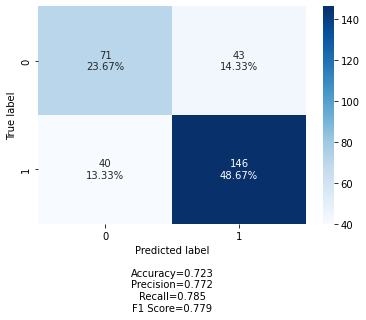

In [107]:
from utils.classification import plot_confusion_matrix

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cf_matrix)

### Conclusion


---

Comment on your findings here and provide a summary. 

Include: 
1. The model you would choose to deploy (if any) 
2. A table of results of the different models you tested
3. Model performance across different subsets (ie, geographies, customer offering, etc.)
  * Should we not deploy for certain subsets/groups?
4. Steps on how to maintain and update the model in production in a way stakeholders can understand

### Appendix


---

Add any exploratory or supporting work that doesn't fit into the story of your report. Add any citations you used here as well.

In [108]:
from sklearn.feature_selection import SelectKBest, f_classif

# Checkout how to integrate feature selection methods inside of your Pipeline here: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html

# Get the max number of features that model can use
processing_and_fe_steps = [
    ('preprocessor', preprocessor),
    ('interactions', PolynomialFeatures())
]
processing_and_fe_pipeline = Pipeline(processing_and_fe_steps)
n_features = processing_and_fe_pipeline.fit_transform(X_train).shape[1]

k_list = np.linspace(10, n_features, dtype="int")
test_accuracys = []
train_accuracys = []
for k in k_list:
    steps = [
        ('preprocessor', preprocessor),
        ('interactions', PolynomialFeatures()),
        ('dim_red', SelectKBest(score_func=f_classif, k=k)),
        ('regressor', RandomForestClassifier())
    ]
    pipeline = Pipeline(steps)

    # Fit the model and score it
    pipeline.fit(X_train, y_train)

    test_accuracy = pipeline.score(X_test, y_test)
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracys.append(test_accuracy)
    train_accuracys.append(train_accuracy)

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users

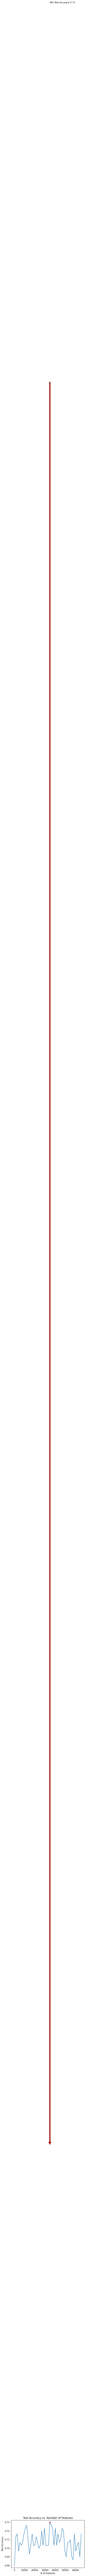

Min Test Accuracy of 0.73 acheived with 34867 features


In [109]:
# Plot Accuracy for various # of features
sns.lineplot(x=k_list, y=test_accuracys)
maxima = []
for i in list(zip(k_list, test_accuracys)):
    if i[1] == max(test_accuracys):
        maxima.append(i)
        for annotation_pt in maxima:
            plt.scatter(annotation_pt[0], annotation_pt[1], marker='o', c="red", s=25)
            annotation_text_position = [annotation_pt[0], annotation_pt[1] * 5]
            plt.annotate(f"Max Test Accuracy {annotation_pt[1]:,.2f}", annotation_pt, xytext=annotation_text_position, arrowprops={'facecolor':'red', "shrink":0.15})
plt.title(f"Test Accuracy vs. Number of Features")
plt.xlabel("# of Features")
plt.ylabel("Test Accuracy")
plt.show()
for annotation_pt in maxima:
    print(f"Max Test Accuracy of {annotation_pt[1]:,.2f} acheived with {annotation_pt[0]} features")